In [4]:
import os, time, json, random, glob, copy
import numpy as np, cv2, matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import models
from albumentations import Compose, Resize, RandomBrightnessContrast, Rotate, HorizontalFlip, Normalize
from albumentations.pytorch import ToTensorV2
from torch.cuda.amp import autocast, GradScaler # For mixed precision training

# ---------------------------
# 0. Thiết lập tham số chung
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2

# Loss weights & thresholds
lambda_unc   = 0.5   # Weight for evidential uncertainty loss
target_risk  = 0.02  # Max allowed risk on kept samples (Currently not used directly, but good for context)
alpha_conf   = 0.05  # Conformal prediction error rate

learning_rate_p1   = 1e-4
learning_rate_p2   = 1e-3 # Tăng learning rate cho pha 2 vì chỉ huấn luyện head nhỏ
batch_size_p1      = 8   # Batch size cho pha 1
batch_size_p2      = 64  # Tăng batch size cho pha 2 (vì chỉ xử lý features, không phải ảnh gốc)
accumulation_steps = 2 # Gradient accumulation
num_epochs_p1      = 10
num_epochs_p2      = 10 # Reduced epochs for lighter phase 2

# Paths
positive_folder  = "COVID"
negative_folder  = "non-COVID"
checkpoint_dir   = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Set environment variable to reduce memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# --- Khắc phục lỗi PyTorch 2.6 numpy global ---
import numpy as np
torch.serialization.add_safe_globals([np._core.multiarray.scalar])
# ---------------------------------------------

# ---------------------------
# 1. Load & split data
# ---------------------------
def load_data_paths():
    pos = glob.glob(os.path.join(positive_folder, "*.png"))
    neg = glob.glob(os.path.join(negative_folder, "*.png"))
    random.shuffle(pos); random.shuffle(neg)
    split_p = int(0.8 * len(pos))
    split_n = int(0.8 * len(neg))
    return pos[:split_p], neg[:split_n], pos[split_p:], neg[split_n:]

train_pos, train_neg, test_pos, test_neg = load_data_paths()

# ---------------------------
# 2. Dataset
# ---------------------------
class CTScanDataset(Dataset):
    def __init__(self, pos_paths, neg_paths, transform):
        self.paths = pos_paths + neg_paths
        self.labels = [0] * len(pos_paths) + [1] * len(neg_paths)
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, i):
        p = self.paths[i]
        l = self.labels[i]
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        img = self.transform(image=img)["image"]
        return img, l, p # Trả về cả đường dẫn để phục vụ debugging/ghi log

# ---------------------------
# 3. Model (Điều chỉnh unc_head để khớp với checkpoint và logic Evidential)
# ---------------------------
class MobileNetV2WithUncertainty(nn.Module):
    def __init__(self, num_classes=2, p_drop=0.5, temperature=1.0):
        super().__init__()
        m = models.mobilenet_v2(pretrained=True)
        # Thêm dropout vào các layer nhất định trong backbone
        # Tắt tự động thêm dropout bằng cách thêm dropout ở cuối mỗi block invert_residual
        # Đảm bảo nhất quán với phiên bản inference của model
        # for idx, layer in enumerate(m.features):
        #    if idx % 5 == 4: layer.add_module("drop", nn.Dropout(p_drop)) # Ví dụ: thêm dropout sau mỗi 5 layer

        self.backbone = m
        self.backbone.classifier = nn.Identity() # Bỏ head phân loại gốc của MobileNetV2
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p_drop)
        self.fc = nn.Linear(self.backbone.last_channel, num_classes)
        # Điều chỉnh tên và cấu trúc unc_head để khớp với Evidential DL và tránh lỗi size mismatch
        self.unc_head = nn.Sequential( # Đổi tên thành unc_head để khớp checkpoint
            nn.Linear(self.backbone.last_channel, 128), nn.ReLU(),
            nn.Dropout(p_drop), 
            nn.Linear(128, num_classes), # Output num_classes (2) giá trị evidence
            nn.Softplus() # Sử dụng Softplus để đảm bảo evidence dương
        )
        self.temperature = nn.Parameter(torch.tensor(temperature))
        self.feature_grad = None
        self.feature_map_for_hook = None # Đổi tên cho rõ ràng

    def save_grad(self, grad): self.feature_grad = grad

    def forward(self, x):
        if x.dim() == 4: # Input là ảnh (Batch, Channels, H, W)
            f = self.backbone.features(x)
            p = self.pool(f).flatten(1)
        elif x.dim() == 2: # Input là feature vector (Batch, Features)
            p = x 
            f = None # Không có feature map khi input là vector
        else:
            raise ValueError("Input tensor must be 2D (features) or 4D (image).")

        p = self.dropout(p)
        logits = self.fc(p) / self.temperature
        evidence = self.unc_head(p) # Gọi đúng tên unc_head
        return logits, evidence

    # Hàm forward riêng để lấy feature map cho Grad-CAM++
    def forward_with_features(self, x):
        f = self.backbone.features(x)
        if f.requires_grad:
            f.register_hook(self.save_grad)
        self.feature_map_for_hook = f.clone() # Lưu feature map để tính alpha trong Grad-CAM++
        p = self.pool(f).flatten(1)
        p = self.dropout(p)
        logits = self.fc(p) / self.temperature
        evidence = self.unc_head(p) # Gọi đúng tên unc_head
        return f, logits, evidence

# ---------------------------
# 4. Helper Functions (Điều chỉnh compute_uncertainty_cam và các metric)
# ---------------------------
def compute_uncertainty(evidence):
    alpha = evidence + 1
    S = alpha.sum(dim=1, keepdim=True)
    uncertainty = num_classes / S
    return uncertainty

def evidential_loss(logits, evidence, y):
    alpha = evidence + 1
    S = alpha.sum(dim=1, keepdim=True)
    # Sử dụng Negative Log Likelihood loss (NLL) cho Evidential:
    nll_loss = -torch.log(alpha[torch.arange(len(y)), y] / S.squeeze() + 1e-10).mean()
    return nll_loss


def optimize_temperature(model, val_loader, device):
    model.eval()
    nll_criterion = nn.CrossEntropyLoss() # Dùng CrossEntropyLoss cho logits (chưa qua temperature)
    optimizer = optim.LBFGS([model.temperature], lr=0.01, max_iter=50, history_size=100)

    def closure():
        optimizer.zero_grad()
        loss = 0
        for x, y, _ in val_loader:
            x, y = x.to(device), y.to(device)
            with autocast():
                # Cần gọi model để nó tính temperature
                # Vì model(x) trả về (logits, evidence), ta cần forward qua backbone và pool trước
                features = model.backbone.features(x)
                pooled_features = model.pool(features).flatten(1)
                logits = model.fc(model.dropout(pooled_features)) / model.temperature # Lấy logits ĐÃ chia temperature
            loss += nll_criterion(logits, y)
        loss.backward()
        return loss

    print(f"Optimizing temperature (initial: {model.temperature.item():.3f})...")
    optimizer.step(closure)
    print(f"Optimized temperature: {model.temperature.item():.3f}")

def compute_nonconformity(model, loader, device, is_features_loader=False):
    model.eval()
    scores = []
    with torch.no_grad():
        for x, y, _ in loader:
            x, y = x.to(device), y.to(device)
            with autocast():
                if is_features_loader:
                    logits, _ = model(x)
                else:
                    logits, _ = model(x)
            probs = F.softmax(logits, dim=1)
            # score = 1 - P(y_true)
            scores.extend([1 - probs[i, y[i]].item() for i in range(len(y))])
            torch.cuda.empty_cache()
    return np.array(scores)

def set_conformal_threshold(scores, alpha=alpha_conf):
    q = np.quantile(scores, 1 - alpha)
    return q

def grad_cam_plus_plus(model, img_tensor, target_class):
    model.eval()
    for param in model.backbone.features.parameters():
        param.requires_grad = True

    if model.feature_grad is not None:
        model.feature_grad = None

    img_input = img_tensor.unsqueeze(0).to(device)
    img_input.requires_grad_(True) 

    with autocast():
        fmap, logits, _ = model.forward_with_features(img_input)
    
    model.zero_grad() 

    score = logits[0, target_class]
    score.backward() 

    grad = model.feature_grad
    if grad is None:
        print("Warning: feature_grad is None. Grad-CAM++ might not work as expected.")
        return np.zeros((fmap.shape[2], fmap.shape[3]))

    weights = F.adaptive_avg_pool2d(grad, (1, 1)).view(grad.shape[1]) 
    
    cam = torch.zeros((fmap.shape[2], fmap.shape[3]), dtype=torch.float32, device=fmap.device)
    for k in range(fmap.shape[1]):
        cam += weights[k] * fmap[0, k] 
    
    cam = F.relu(cam) 

    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-10) 

    for param in model.backbone.features.parameters():
        param.requires_grad = False

    return cam.cpu().numpy()


def patch_uncertainty(fmap, patch_size=16):
    fmap = fmap.float()
    B, C, H, W = fmap.shape
    
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    fmap_reshaped = fmap.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    fmap_reshaped = fmap_reshaped.permute(0, 2, 3, 1, 4, 5).contiguous() # B, Nh, Nw, C, Ph, Pw
    
    patch_var = fmap_reshaped.var(dim=(-2, -1)).mean(dim=-1) # B, Nh, Nw

    return patch_var.view(B, num_patches_h, num_patches_w)


def generate_heatmaps(model, img_tensor, target_class):
    cam = grad_cam_plus_plus(model, img_tensor, target_class)
    
    model.eval()
    with torch.no_grad():
        with autocast():
            fmap, _, evidence = model.forward_with_features(img_tensor.unsqueeze(0).to(device))
    
    unc_map = patch_uncertainty(fmap).cpu().numpy()[0]
    unc_map = (unc_map - unc_map.min()) / (unc_map.max() + 1e-10)
    return cam, unc_map

# ---------------------------
# 5. Train/Validate Functions
# ---------------------------
def train_one_epoch(model, loader, cls_crit, opt, scaler, accumulation_steps, is_features_loader=False):
    model.train()
    tot_loss = tot_cls = tot_unc = 0; correct = 0; N = 0
    opt.zero_grad()
    for i, (x, y, _) in enumerate(loader): # _ for paths
        x, y = x.to(device), y.to(device)
        with autocast():
            if is_features_loader:
                logits, evidence = model(x)
            else:
                logits, evidence = model(x)

            l_cls = cls_crit(logits, y)
            l_unc = evidential_loss(logits, evidence, y)
            loss = (l_cls + lambda_unc * l_unc) / accumulation_steps
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.step(opt)
            scaler.update()
            opt.zero_grad()
        bs = x.size(0); N += bs
        tot_loss += loss.item() * bs * accumulation_steps
        tot_cls += l_cls.item() * bs
        tot_unc += l_unc.item() * bs
        correct += (logits.argmax(1) == y).sum().item()
        torch.cuda.empty_cache()
    return tot_loss / N, tot_cls / N, tot_unc / N, correct / N

def validate_one_epoch(model, loader, cls_crit, tau_conf, tau_unc): # Thêm tau_unc làm tham số
    model.eval()
    tot_loss = 0; N = 0
    all_conf = []; all_unc_global = []; all_true = []; all_pred = []; all_paths = []
    
    rejected_count = 0
    correct_rejections = 0 
    false_rejections = 0 
    
    non_rejected_correct = 0
    non_rejected_total = 0

    with torch.no_grad():
        for x, y, p in loader:
            x, y = x.to(device), y.to(device)
            with autocast():
                logits, evidence = model(x) 
            
            probs = F.softmax(logits, dim=1)
            conf, _ = probs.max(1)
            
            u_global_tensor = compute_uncertainty(evidence) 
            u_global = u_global_tensor.squeeze() 

            l_cls = cls_crit(logits, y)
            tot_loss += l_cls.item() * x.size(0); N += x.size(0)
            
            all_conf.append(np.atleast_1d(conf.cpu().numpy()))
            all_unc_global.append(np.atleast_1d(u_global.cpu().numpy()))
            all_true.append(y.cpu().numpy())
            all_pred.append(logits.argmax(1).cpu().numpy())
            all_paths.extend(p)
            torch.cuda.empty_cache()

            is_rejected = (conf < tau_conf) & (u_global > tau_unc) 
            
            for i in range(x.size(0)):
                if is_rejected[i]:
                    rejected_count += 1
                    if logits.argmax(1)[i] != y[i]:
                        correct_rejections += 1
                    else: 
                        false_rejections += 1
                else: 
                    non_rejected_total += 1
                    if logits.argmax(1)[i] == y[i]:
                        non_rejected_correct += 1

    confs = np.concatenate(all_conf)
    uncs = np.concatenate(all_unc_global)
    trues = np.concatenate(all_true)
    preds = np.concatenate(all_pred)
    
    coverage = (non_rejected_total / N) if N > 0 else 0.0
    selective_acc = (non_rejected_correct / non_rejected_total) if non_rejected_total > 0 else 0.0
    risk = 1 - selective_acc 

    rejection_accuracy = (correct_rejections / rejected_count) if rejected_count > 0 else 0.0

    # missed_rejections = ((preds != trues) & ~is_rejected).sum() # is_rejected là tensor của batch hiện tại, cần tính lại cho toàn bộ dataset
    # Sửa: is_rejected cần được tính từ toàn bộ confs và uncs sau khi concatenate
    is_rejected_total = (confs < tau_conf) & (uncs > tau_unc)
    missed_rejections = ((preds != trues) & ~is_rejected_total).sum() 


    print(f"  Val Coverage: {coverage:.3f} | Sel Acc: {selective_acc:.3f} | Risk: {risk:.3f}")
    print(f"  Total Rejected: {rejected_count} | Correct Rejects: {correct_rejections} | False Rejects: {false_rejections}")
    print(f"  Missed Rejects: {missed_rejections} | Rejection Acc: {rejection_accuracy:.3f}")

    return {
        'loss': tot_loss / N,
        'coverage': coverage,
        'selective_acc': selective_acc,
        'risk': risk,
        'total_rejected': rejected_count,
        'correct_rejects': correct_rejections,
        'false_rejects': false_rejections, 
        'missed_rejects': missed_rejections, 
        'rejection_accuracy': rejection_accuracy, 
        'confidences': confs, 'uncertainties': uncs, # Trả về các mảng này
        'true_labels': trues, 'predictions': preds, # Trả về các mảng này
        'paths': all_paths
    }

# ----------------------------------------
# NEW: Function to extract features for Phase 2
# ----------------------------------------
def extract_features(model, loader, device):
    model.eval()
    all_features = []
    all_labels = []
    all_paths = []
    print("Extracting features for Phase 2 training...")
    with torch.no_grad():
        for i, (x, y, p) in enumerate(loader):
            x = x.to(device)
            with autocast():
                f = model.backbone.features(x)
                pooled_f = model.pool(f).flatten(1)
            all_features.append(pooled_f.cpu())
            all_labels.append(y.cpu())
            all_paths.extend(p)
            torch.cuda.empty_cache()
            if (i+1) % 100 == 0:
                print(f"Processed {i+1} batches for feature extraction.")
    print("Feature extraction complete.")
    return torch.cat(all_features, dim=0), torch.cat(all_labels, dim=0), all_paths

# ---------------------------
# 6. Run Training
# ---------------------------
def run_training():
    train_tf = Compose([Resize(224,224), RandomBrightnessContrast(0.2,0.2,p=0.5),
                        Rotate(40,p=0.5), HorizontalFlip(p=0.5),
                        Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
                        ToTensorV2()])
    test_tf  = Compose([Resize(224,224), Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]), ToTensorV2()])
    
    train_ds = CTScanDataset(train_pos, train_neg, train_tf)
    test_ds  = CTScanDataset(test_pos, test_neg, test_tf) 
    
    train_ld_p1 = DataLoader(train_ds, batch_size_p1, shuffle=True, num_workers=2, pin_memory=True)
    test_ld     = DataLoader(test_ds, batch_size_p1, shuffle=False, num_workers=2, pin_memory=True)

    model = MobileNetV2WithUncertainty().to(device)
    cls_crit = nn.CrossEntropyLoss()
    scaler = GradScaler()

    # --- Phase 1: Train classifier ---
    print("\n--- Starting Phase 1: Training Classifier ---")
    unc_head_params = set(model.unc_head.parameters())
    
    for p in model.parameters(): # Đảm bảo tất cả được mở grad trước
        p.requires_grad = True
    for p in unc_head_params: # Sau đó đóng băng unc_head
        p.requires_grad = False
    
    opt1 = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate_p1)
    
    best_selective_acc_p1 = 0 
    best_w1 = copy.deepcopy(model.state_dict())
    
    initial_tau_conf = 0.5 
    initial_tau_unc = 0.5 
    
    for e in range(num_epochs_p1):
        t_loss, t_cls, t_unc, t_acc = train_one_epoch(model, train_ld_p1, cls_crit, opt1, scaler, accumulation_steps, is_features_loader=False)
        val_p1_epoch_results = validate_one_epoch(model, test_ld, cls_crit, initial_tau_conf, initial_tau_unc) # Lấy kết quả val của epoch này
        print(f"[P1][Epoch {e+1}/{num_epochs_p1}] Train Loss: {t_loss:.4f} (CLS: {t_cls:.4f}, UNC: {t_unc:.4f}) Acc: {t_acc:.3f} | Val Cov: {val_p1_epoch_results['coverage']:.3f} Sel Acc: {val_p1_epoch_results['selective_acc']:.3f} Risk: {val_p1_epoch_results['risk']:.3f} | Rej Acc: {val_p1_epoch_results['rejection_accuracy']:.3f}")
    
        if val_p1_epoch_results['selective_acc'] > best_selective_acc_p1:
            best_selective_acc_p1 = val_p1_epoch_results['selective_acc']
            best_w1 = copy.deepcopy(model.state_dict())
            print(f"    New best P1 model saved with Sel Acc: {best_selective_acc_p1:.3f}")
    
    model.load_state_dict(best_w1)
    print("Phase 1 training complete. Loaded best model.")
    torch.cuda.empty_cache()

    # --- Optimize Temperature ---
    optimize_temperature(model, test_ld, device)
    torch.cuda.empty_cache()

    # --- Feature Extraction for Phase 2 ---
    train_features, train_labels, train_paths_features = extract_features(model, train_ld_p1, device)
    train_ds_p2 = TensorDataset(train_features, train_labels, torch.tensor([i for i in range(len(train_labels))])) 
    train_ld_p2 = DataLoader(train_ds_p2, batch_size_p2, shuffle=True, num_workers=2, pin_memory=True)
    
    del train_features, train_labels 
    torch.cuda.empty_cache()

    # --- Phase 2: Train only Uncertainty Head ---
    print("\n--- Starting Phase 2: Training Uncertainty Head ---")
    for p in model.parameters():
        p.requires_grad = False
    for p in model.unc_head.parameters(): # Mở đóng băng cho unc_head
        p.requires_grad = True
    
    opt2 = optim.Adam(model.unc_head.parameters(), lr=learning_rate_p2)
    
    best_rejection_acc_p2 = -1.0 
    best_w2 = copy.deepcopy(model.state_dict())

    scores_p2_init = compute_nonconformity(model, test_ld, device, is_features_loader=False)
    tau_conf_p2_eval = set_conformal_threshold(scores_p2_init, alpha_conf) 
    tau_unc_p2_eval = 0.05 

    for e in range(num_epochs_p2):
        t_loss, t_cls, t_unc, t_acc = train_one_epoch(model, train_ld_p2, cls_crit, opt2, scaler, accumulation_steps, is_features_loader=True)
        val_p2_epoch_results = validate_one_epoch(model, test_ld, cls_crit, tau_conf_p2_eval, tau_unc_p2_eval) # Lấy kết quả val của epoch này
        print(f"[P2][Epoch {e+1}/{num_epochs_p2}] Train Loss: {t_loss:.4f} (CLS: {t_cls:.4f}, UNC: {t_unc:.4f}) Acc: {t_acc:.3f} | Val Cov: {val_p2_epoch_results['coverage']:.3f} Sel Acc: {val_p2_epoch_results['selective_acc']:.3f} Risk: {val_p2_epoch_results['risk']:.3f} | Rej Acc: {val_p2_epoch_results['rejection_accuracy']:.3f}")
        
        if val_p2_epoch_results['rejection_accuracy'] > best_rejection_acc_p2: 
            best_rejection_acc_p2 = val_p2_epoch_results['rejection_accuracy']
            best_w2 = copy.deepcopy(model.state_dict())
            print(f"    New best P2 model saved with Rejection Acc: {best_rejection_acc_p2:.3f}")
            
    model.load_state_dict(best_w2) # Tải lại model tốt nhất sau P2
    print("Phase 2 training complete. Loaded best model.")
    torch.cuda.empty_cache()

    # --- Calibrate Conformal Threshold ---
    print("\n--- Calibrating Conformal Thresholds ---")
    scores_final = compute_nonconformity(model, test_ld, device, is_features_loader=False)
    final_tau_conf = set_conformal_threshold(scores_final, alpha_conf)
    print(f"Calibrated final conformal threshold (tau_conf): {final_tau_conf:.3f}")

    # --- Xác định tau_unc (Uncertainty Threshold) ---
    # Chạy validate_one_epoch MỘT LẦN NỮA với model tốt nhất của P2
    # để lấy các mảng confidences, uncertainties, true_labels, predictions
    print("\nRe-evaluating model for final tau_unc search...")
    # Dùng tau_conf đã tính toán, và một tau_unc tạm thời (ví dụ: 0.0) để thu thập tất cả dữ liệu
    final_model_eval_results_for_tau_search = validate_one_epoch(model, test_ld, cls_crit, final_tau_conf, 0.0)
    
    # Lấy các mảng cần thiết từ kết quả lần đánh giá này
    confs = final_model_eval_results_for_tau_search['confidences']
    uncs = final_model_eval_results_for_tau_search['uncertainties']
    trues = final_model_eval_results_for_tau_search['true_labels']
    preds = final_model_eval_results_for_tau_search['predictions']
    total_samples_N = len(trues) # Tổng số mẫu trong tập test
    
    print("\nFinding optimal tau_unc...")
    test_unc_values = np.linspace(0.01, 0.2, 20) 
    best_tau_unc_found = 0.0 
    max_rejection_performance = -float('inf')

    for current_tau_unc in test_unc_values:
        # Áp dụng logic từ chối với final_tau_conf và current_tau_unc
        is_rejected_curr = (confs < final_tau_conf) & (uncs > current_tau_unc)
        
        rejected_count_curr = is_rejected_curr.sum()
        non_rejected_total_curr = total_samples_N - rejected_count_curr 

        correct_rejections_curr = ((preds != trues) & is_rejected_curr).sum()
        false_rejections_curr = ((preds == trues) & is_rejected_curr).sum()

        rejection_accuracy_curr = (correct_rejections_curr / rejected_count_curr) if rejected_count_curr > 0 else 0.0
        
        current_performance = rejection_accuracy_curr 

        if current_performance > max_rejection_performance:
            max_rejection_performance = current_performance
            best_tau_unc_found = current_tau_unc
            
    final_tau_unc = best_tau_unc_found
    print(f"Optimal tau_unc found: {final_tau_unc:.4f} (with Rejection Performance: {max_rejection_performance:.3f})")


    # --- Final Validation with Calibrated Threshold ---
    print("\n--- Performing Final Validation with Calibrated Thresholds ---")
    final_val_results = validate_one_epoch(model, test_ld, cls_crit, final_tau_conf, final_tau_unc)
    print(f"Final Validation Metrics:")
    print(f"  Coverage: {final_val_results['coverage']:.3f}")
    print(f"  Selective Accuracy (on kept): {final_val_results['selective_acc']:.3f}")
    print(f"  Risk on Kept Samples: {final_val_results['risk']:.3f}")
    print(f"  Total Rejected: {final_val_results['total_rejected']}")
    print(f"  Correct Rejects: {final_val_results['correct_rejects']}")
    print(f"  False Rejects: {final_val_results['false_rejects']}")
    print(f"  Missed Rejects: {final_val_results['missed_rejects']}")
    print(f"  Rejection Accuracy: {final_val_results['rejection_accuracy']:.3f}")

    # Save final model and thresholds
    torch.save({
        'state': model.state_dict(), 
        'tau_conf': final_tau_conf,
        'tau_unc': final_tau_unc
    }, os.path.join(checkpoint_dir, "final_model_with_tau_and_unc.pth"))
    print(f"Final model and conformal thresholds saved to {os.path.join(checkpoint_dir, 'final_model_with_tau_and_unc.pth')}")
    
    return model, final_tau_conf, final_tau_unc

# ---------------------------
# Main
# ---------------------------
if __name__ == "__main__":
    final_model, tc, tunc = run_training()
    print("Done. Final Conformal Threshold:", tc)
    print("Done. Final Uncertainty Threshold:", tunc)


--- Starting Phase 1: Training Classifier ---


/tmp/ipykernel_1730/1626194030.py:422: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_1730/1626194030.py:274: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


/tmp/ipykernel_1730/1626194030.py:311: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Val Coverage: 1.000 | Sel Acc: 0.920 | Risk: 0.080
  Total Rejected: 0 | Correct Rejects: 0 | False Rejects: 0
  Missed Rejects: 40 | Rejection Acc: 0.000
[P1][Epoch 1/10] Train Loss: 0.7255 (CLS: 0.4018, UNC: 0.6473) Acc: 0.817 | Val Cov: 1.000 Sel Acc: 0.920 Risk: 0.080 | Rej Acc: 0.000
    New best P1 model saved with Sel Acc: 0.920
  Val Coverage: 1.000 | Sel Acc: 0.938 | Risk: 0.062
  Total Rejected: 0 | Correct Rejects: 0 | False Rejects: 0
  Missed Rejects: 31 | Rejection Acc: 0.000
[P1][Epoch 2/10] Train Loss: 0.5468 (CLS: 0.2792, UNC: 0.5353) Acc: 0.880 | Val Cov: 1.000 Sel Acc: 0.938 Risk: 0.062 | Rej Acc: 0.000
    New best P1 model saved with Sel Acc: 0.938
  Val Coverage: 1.000 | Sel Acc: 0.960 | Risk: 0.040
  Total Rejected: 0 | Correct Rejects: 0 | False Rejects: 0
  Missed Rejects: 20 | Rejection Acc: 0.000
[P1][Epoch 3/10] Train Loss: 0.4676 (CLS: 0.2267, UNC: 0.4818) Acc: 0.910 | Val Cov: 1.000 Sel Acc: 0.960 Risk: 0.040 | Rej Acc: 0.000
    New best P1 model saved 

/tmp/ipykernel_1730/1626194030.py:162: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Optimized temperature: 0.793
Extracting features for Phase 2 training...


/tmp/ipykernel_1730/1626194030.py:392: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Processed 100 batches for feature extraction.
Processed 200 batches for feature extraction.
Feature extraction complete.

--- Starting Phase 2: Training Uncertainty Head ---


/tmp/ipykernel_1730/1626194030.py:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Val Coverage: 1.000 | Sel Acc: 0.990 | Risk: 0.010
  Total Rejected: 0 | Correct Rejects: 0 | False Rejects: 0
  Missed Rejects: 5 | Rejection Acc: 0.000
[P2][Epoch 1/10] Train Loss: 0.0978 (CLS: 0.0320, UNC: 0.1316) Acc: 0.992 | Val Cov: 1.000 Sel Acc: 0.990 Risk: 0.010 | Rej Acc: 0.000
    New best P2 model saved with Rejection Acc: 0.000
  Val Coverage: 1.000 | Sel Acc: 0.990 | Risk: 0.010
  Total Rejected: 0 | Correct Rejects: 0 | False Rejects: 0
  Missed Rejects: 5 | Rejection Acc: 0.000
[P2][Epoch 2/10] Train Loss: 0.0651 (CLS: 0.0343, UNC: 0.0615) Acc: 0.990 | Val Cov: 1.000 Sel Acc: 0.990 Risk: 0.010 | Rej Acc: 0.000
  Val Coverage: 1.000 | Sel Acc: 0.990 | Risk: 0.010
  Total Rejected: 0 | Correct Rejects: 0 | False Rejects: 0
  Missed Rejects: 5 | Rejection Acc: 0.000
[P2][Epoch 3/10] Train Loss: 0.0569 (CLS: 0.0321, UNC: 0.0496) Acc: 0.990 | Val Cov: 1.000 Sel Acc: 0.990 Risk: 0.010 | Rej Acc: 0.000
  Val Coverage: 1.000 | Sel Acc: 0.990 | Risk: 0.010
  Total Rejected: 0 

✔️ Đã load model từ: checkpoints/final_model_with_tau.pth
✔️ Đã load ngưỡng: tau_conf=0.600, tau_unc=0.0500

Tổng số ảnh test: 2481
  Đã chạy inference 50/2481 ảnh → Rejected: 0
  Đã chạy inference 100/2481 ảnh → Rejected: 0
  Đã chạy inference 150/2481 ảnh → Rejected: 0
  Đã chạy inference 200/2481 ảnh → Rejected: 0
  Đã chạy inference 250/2481 ảnh → Rejected: 0
  Đã chạy inference 300/2481 ảnh → Rejected: 0
  Đã chạy inference 350/2481 ảnh → Rejected: 0
  Đã chạy inference 400/2481 ảnh → Rejected: 0
  Đã chạy inference 450/2481 ảnh → Rejected: 2
  Đã chạy inference 500/2481 ảnh → Rejected: 2
  Đã chạy inference 550/2481 ảnh → Rejected: 2
  Đã chạy inference 600/2481 ảnh → Rejected: 3
  Đã chạy inference 650/2481 ảnh → Rejected: 3
  Đã chạy inference 700/2481 ảnh → Rejected: 3
  Đã chạy inference 750/2481 ảnh → Rejected: 3
  Đã chạy inference 800/2481 ảnh → Rejected: 3
  Đã chạy inference 850/2481 ảnh → Rejected: 4
  Đã chạy inference 900/2481 ảnh → Rejected: 5
  Đã chạy inference 950

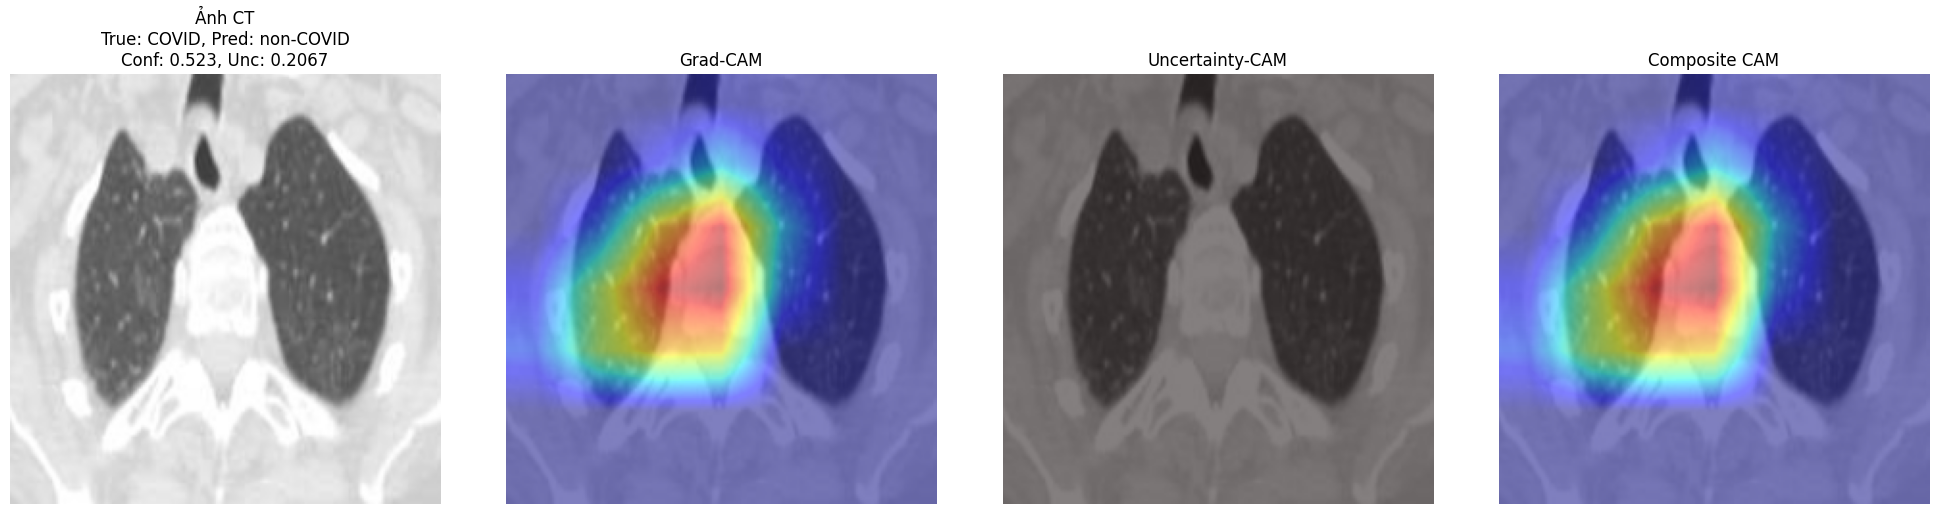

--- Case 2: Non-Covid (254).png ---
  Nhãn thật: non-COVID | Dự đoán: COVID (Sai)
  Conf: 0.533 (Dưới 0.600) | Unc: 0.2308 (Trên 0.0500)


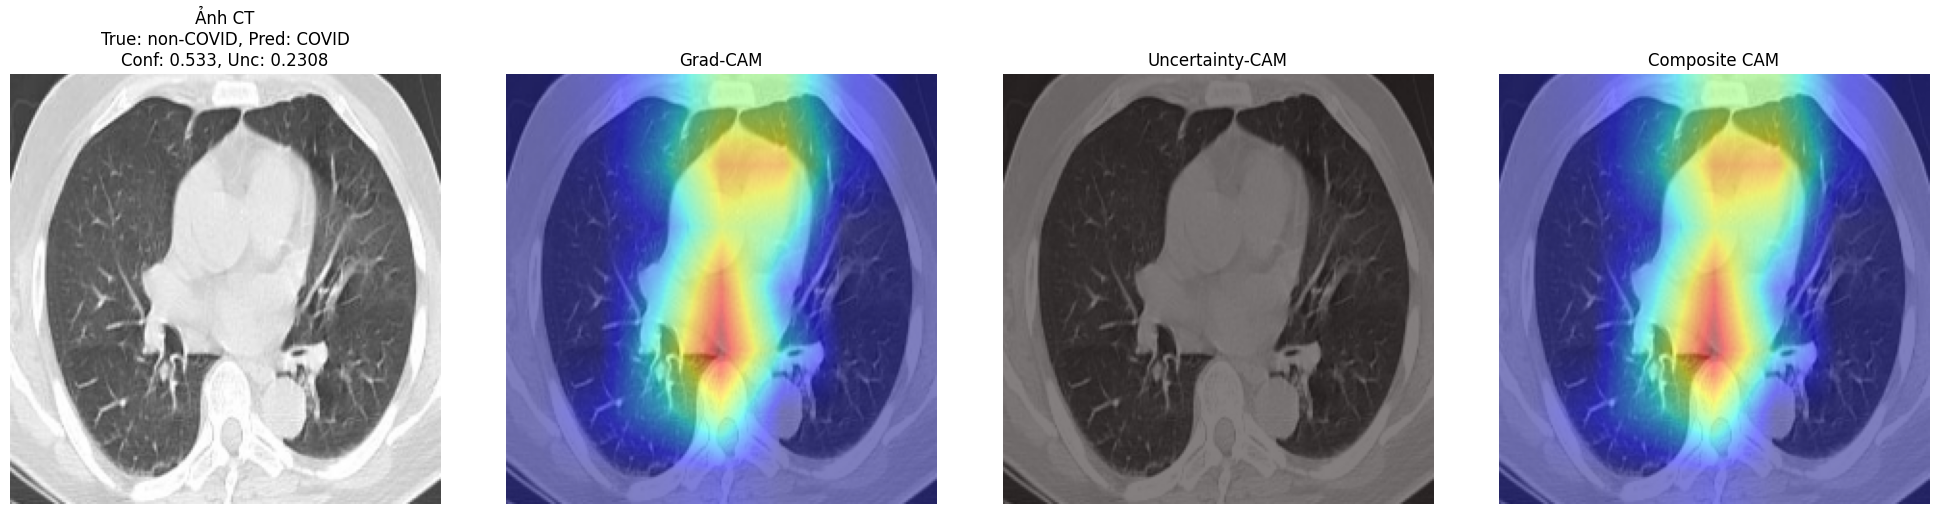

--- Case 3: Non-Covid (348).png ---
  Nhãn thật: non-COVID | Dự đoán: COVID (Sai)
  Conf: 0.529 (Dưới 0.600) | Unc: 0.2868 (Trên 0.0500)


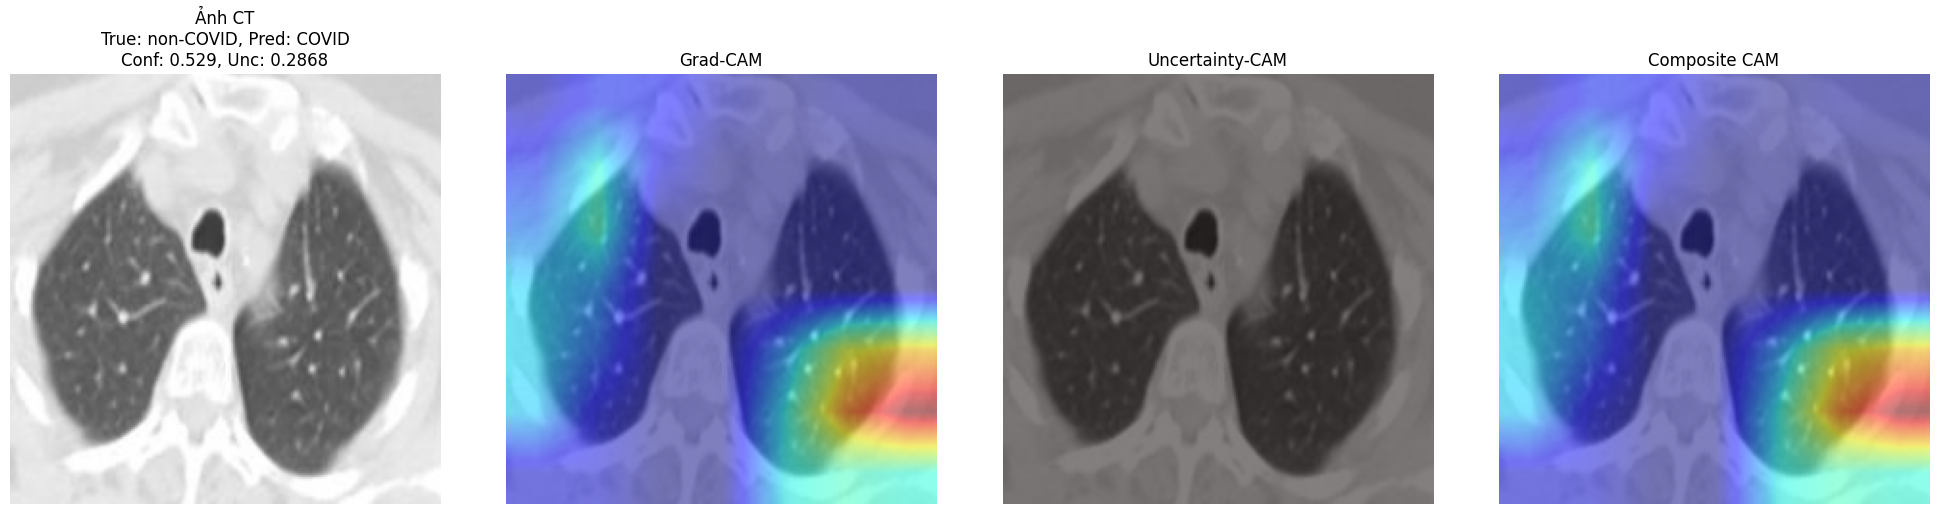

--- Case 4: Covid (1219).png ---
  Nhãn thật: COVID | Dự đoán: non-COVID (Sai)
  Conf: 0.566 (Dưới 0.600) | Unc: 0.2252 (Trên 0.0500)


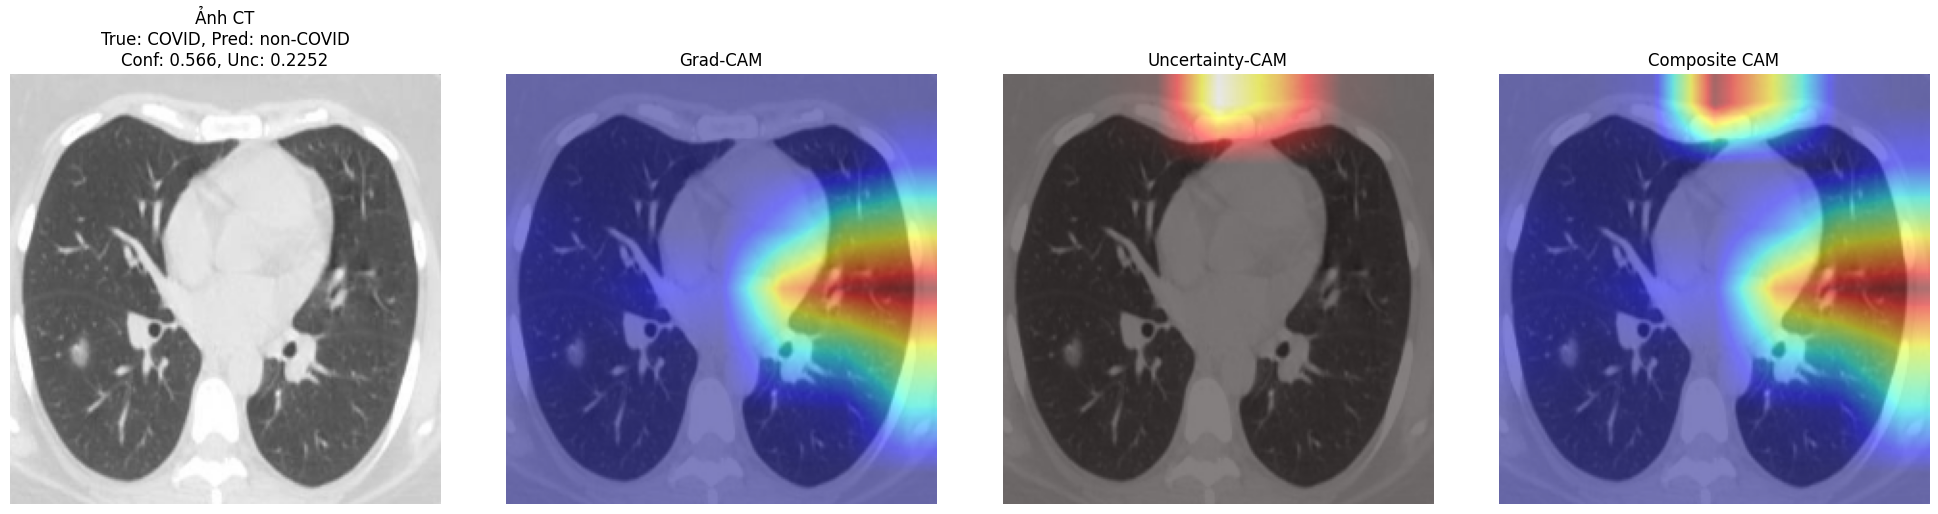

--- Case 5: Covid (1226).png ---
  Nhãn thật: COVID | Dự đoán: non-COVID (Sai)
  Conf: 0.543 (Dưới 0.600) | Unc: 0.2410 (Trên 0.0500)


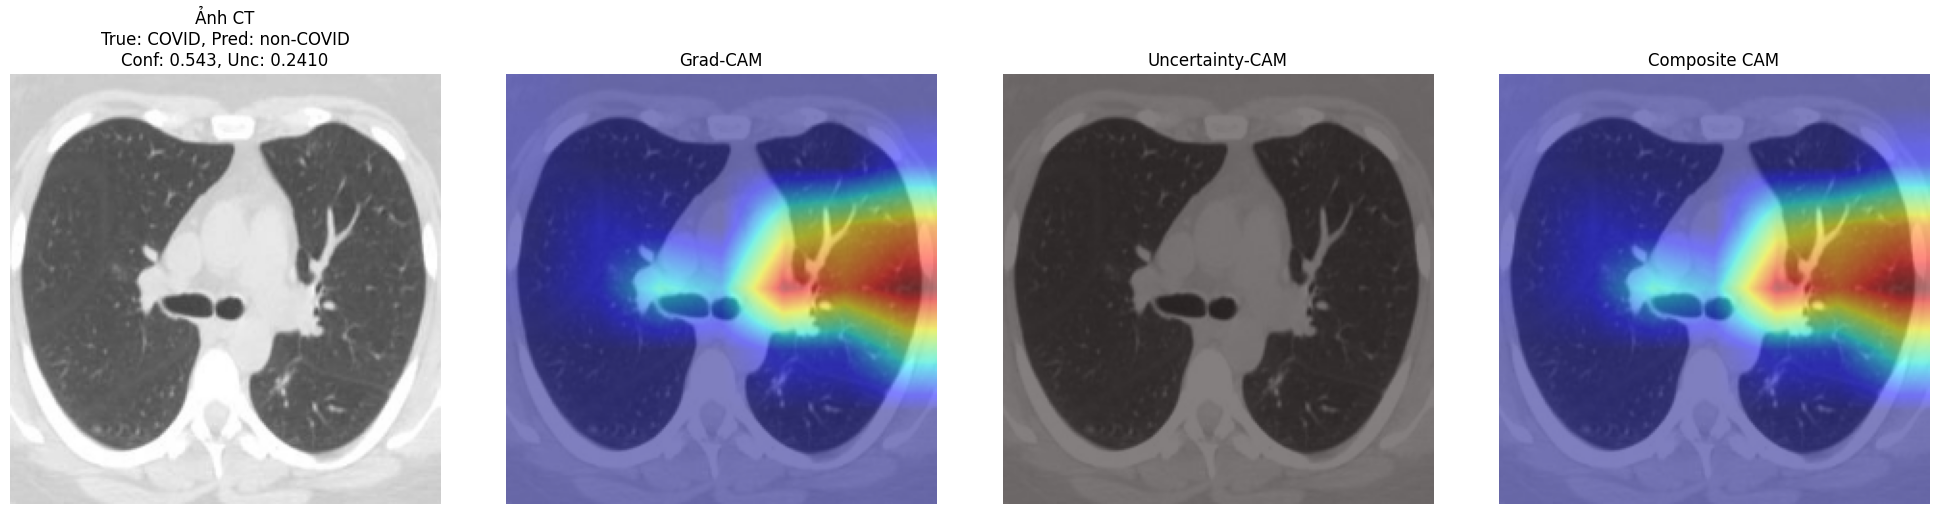

  ... và 1 case từ chối đúng khác.

=== CÁC CASE PHÂN LOẠI SAI NHƯNG KHÔNG BỊ TỪ CHỐI (MISSED REJECTIONS) ===
--- Case 1: Covid (637).png ---
  Nhãn thật: COVID | Dự đoán: non-COVID (Sai)
  Conf: 0.743 | Unc: 0.1655


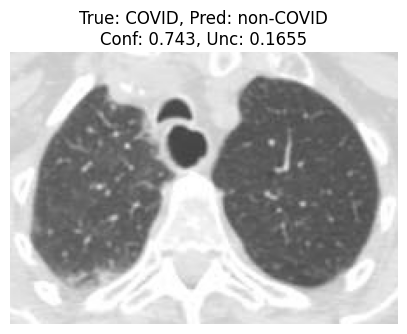

--- Case 2: Non-Covid (197).png ---
  Nhãn thật: non-COVID | Dự đoán: COVID (Sai)
  Conf: 0.623 | Unc: 0.1804


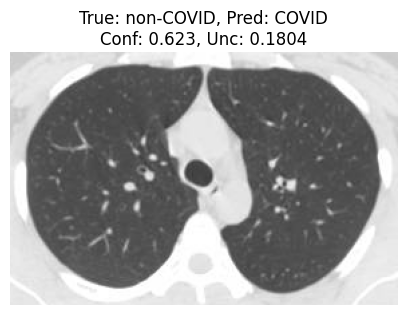

--- Case 3: Non-Covid (351).png ---
  Nhãn thật: non-COVID | Dự đoán: COVID (Sai)
  Conf: 0.870 | Unc: 0.2260


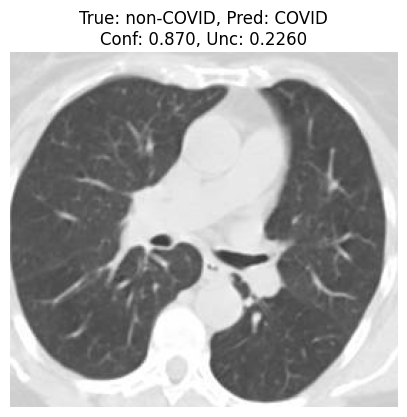

--- Case 4: Covid (1218).png ---
  Nhãn thật: COVID | Dự đoán: non-COVID (Sai)
  Conf: 0.813 | Unc: 0.1425


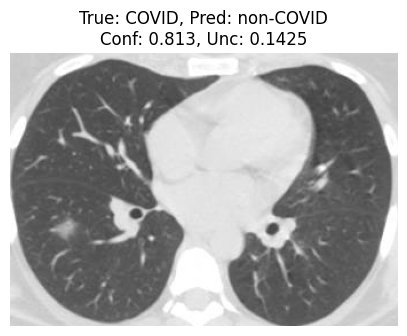

--- Case 5: Covid (467).png ---
  Nhãn thật: COVID | Dự đoán: non-COVID (Sai)
  Conf: 0.910 | Unc: 0.1674


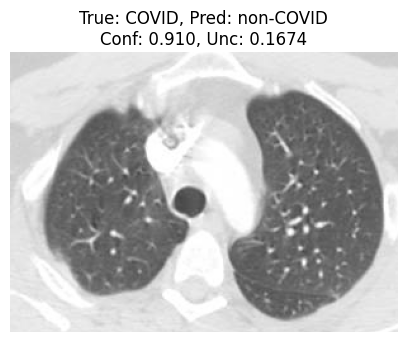

  ... và 12 case bị bỏ lỡ khác.

=== CÁC CASE BỊ TỪ CHỐI SAI (CORRECTLY CLASSIFIED NHƯNG BỊ TỪ CHỐI) ===
--- Case 1: Non-Covid (1027).png ---
  Nhãn thật: non-COVID | Dự đoán: non-COVID (Đúng)
  Conf: 0.533 (Dưới 0.600) | Unc: 0.2051 (Trên 0.0500)


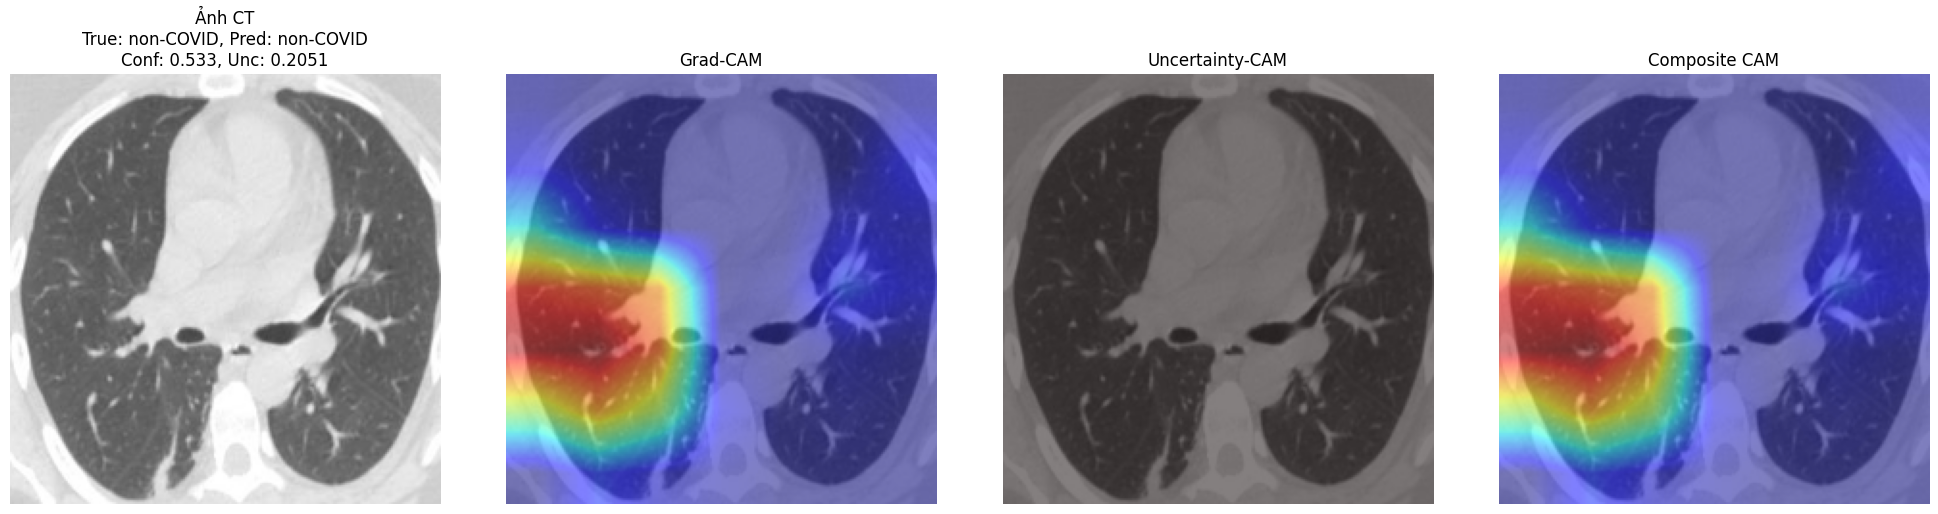

--- Case 2: Non-Covid (339).png ---
  Nhãn thật: non-COVID | Dự đoán: non-COVID (Đúng)
  Conf: 0.526 (Dưới 0.600) | Unc: 0.1977 (Trên 0.0500)


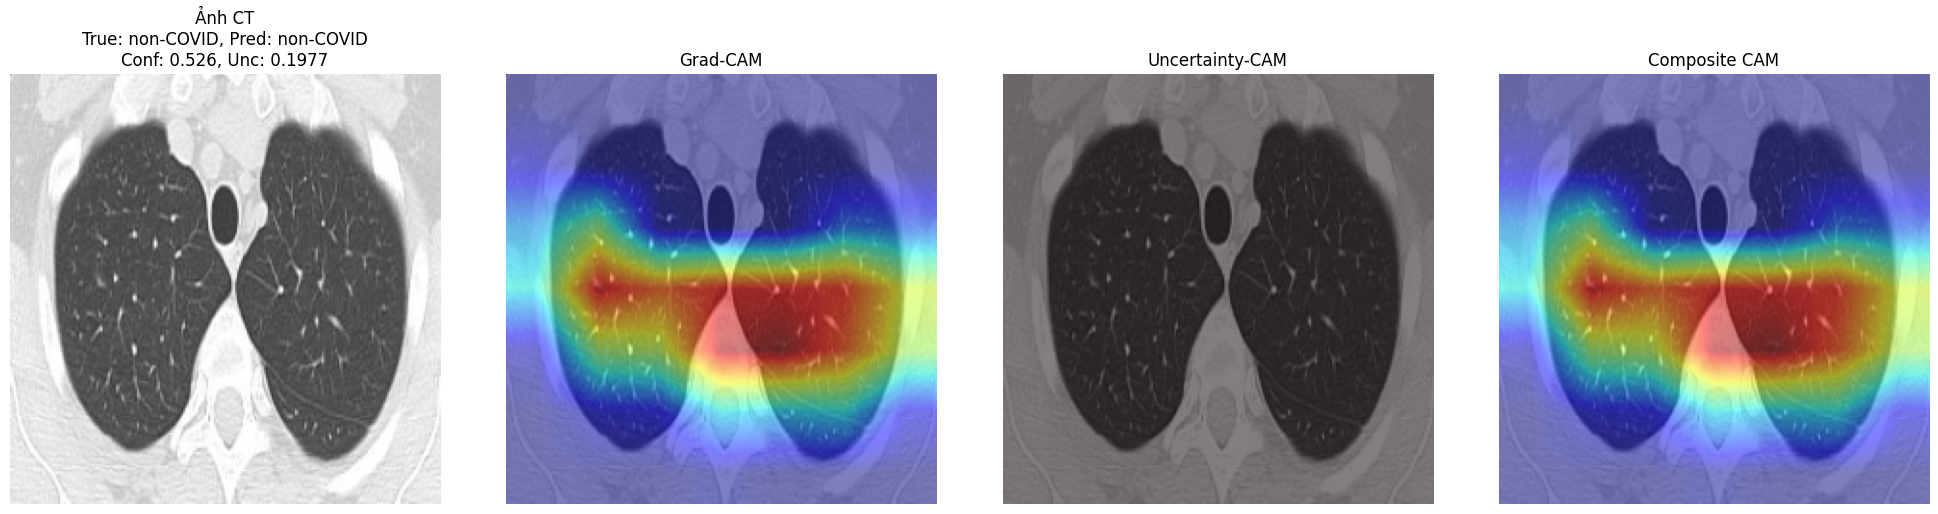


Hoàn tất inference toàn tập test.
Số lượng ảnh bị rejected                : 8
Số lượng ảnh từ chối đúng (misclassified): 6
Tỉ lệ từ chối đúng                      : 75.00%
Tỉ lệ chính xác trên ảnh không từ chối : 99.31%
Số lượng ảnh bị phân loại sai (tổng)  : 23


In [ ]:
import os
import glob
import random

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torchvision import models
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch import ToTensorV2

# ---------------------------
# 0. Thiết lập chung
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Đường dẫn tới model checkpoint đã train xong
CHECKPOINT_PATH = "checkpoints/final_model_with_tau.pth" # Đây là file lưu cả state_dict và tau

# Thư mục chứa ảnh test (COVID / non-COVID)
TEST_POS_FOLDER = "COVID"
TEST_NEG_FOLDER = "non-COVID"

# Các nhãn cho dễ đọc
CLASS_NAMES = {0: "COVID", 1: "non-COVID"}

# ---------------------------
# 1. Định nghĩa Model MobileNetV2WithUncertainty
#    (Lưu ý: Uncertainty Head giờ đây dự đoán một giá trị U_global duy nhất)
# ---------------------------
class MobileNetV2WithUncertainty(nn.Module):
    def __init__(self, num_classes=2, p_dropout=0.5, temperature=1.0):
        super(MobileNetV2WithUncertainty, self).__init__()
        backbone = models.mobilenet_v2(pretrained=True)
        # Thêm dropout vào các layer nhất định trong backbone nếu muốn
        # Bỏ qua vòng lặp này nếu bạn không muốn thêm dropout vào giữa backbone
        # for idx, layer in enumerate(backbone.features):
        #     if isinstance(layer, models.mobilenetv2.InvertedResidual) and len(layer.conv) > 2:
        #         # Tìm vị trí phù hợp để thêm dropout, ví dụ sau conv cuối của block
        #         # Đây là một ví dụ, cần kiểm tra cấu trúc chính xác của MobileNetV2
        #         # để thêm dropout đúng chỗ nếu muốn áp dụng cho backbone.
        #         # Hiện tại, tôi sẽ dựa vào dropout ở lớp pooling cuối cùng
        #         pass

        self.backbone = backbone
        self.backbone.classifier = nn.Identity()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=p_dropout)

        self.fc = nn.Linear(self.backbone.last_channel, num_classes)
        # Modified: Uncertainty head dự đoán một giá trị duy nhất (global uncertainty)
        self.unc_head = nn.Sequential(
            nn.Linear(self.backbone.last_channel, 128),
            nn.ReLU(),
            nn.Dropout(p=p_dropout),
            nn.Linear(128, num_classes), # <-- THAY ĐỔI TỪ 1 THÀNH num_classes (là 2)
            # Vì unc_head bây giờ trả về evidence cho mỗi lớp, chúng ta không dùng Sigmoid ở đây.
            # Thay vào đó, nó sẽ là Softplus, giống như trong training code gốc của bạn
            nn.Softplus() # <-- QUAN TRỌNG: DÙNG SOFTPLUS ĐỂ SINH EVIDENCE DƯƠNG
        )
        # Temperature là một tham số cần thiết cho việc hiệu chỉnh xác suất,
        # và nó nên được tải từ checkpoint đã train.
        self.temperature = nn.Parameter(torch.tensor(temperature)) 

        self.feature_grad = None # Để lưu gradient của feature map
        self.feature_map_for_hook = None # Để lưu feature map cho hook

    def save_feature_grad(self, grad):
        self.feature_grad = grad

    def forward(self, x):
        # Nếu x là ảnh (4D), chạy qua backbone
        if x.dim() == 4:
            features = self.backbone.features(x)
            pooled = self.pool(features)
            flat = torch.flatten(pooled, 1)
        # Nếu x đã là feature vector (2D), bỏ qua backbone và pooling
        elif x.dim() == 2:
            flat = x
        else:
            raise ValueError("Input tensor must be 2D (features) or 4D (image).")

        flat = self.dropout(flat)
        logits = self.fc(flat) / self.temperature # Chia cho temperature để hiệu chỉnh
        u_pred = self.unc_head(flat) # Global uncertainty (0-1)
        return logits, u_pred

    def forward_with_features(self, x):
        features = self.backbone.features(x)
        # Register hook to save gradients of features
        if features.requires_grad:
            features.register_hook(self.save_feature_grad)
        
        # Save feature map for Grad-CAM++ calculations (e.g., for alpha_num/denom in Grad-CAM++)
        # Mặc dù hàm compute_gradcam bạn dùng không dùng fmap.clone() cho alpha,
        # việc có fmap ở đây vẫn hữu ích nếu bạn muốn mở rộng Grad-CAM++
        self.feature_map_for_hook = features.clone() 

        pooled = self.pool(features)
        flat = torch.flatten(pooled, 1)
        flat = self.dropout(flat)

        logits = self.fc(flat) / self.temperature
        u_pred = self.unc_head(flat)
        return self.feature_map_for_hook, logits, u_pred


# ---------------------------
# 2. Hàm compute_gradcam & compute_uncertainty_cam
# ---------------------------
def compute_gradcam(model, img_tensor):
    model.eval()
    # Đảm bảo gradient được kích hoạt cho backbone.features khi cần
    for param in model.backbone.features.parameters():
        param.requires_grad = True

    # Xóa gradient cũ
    if model.feature_grad is not None:
        model.feature_grad = None

    fmap, logits, _ = model.forward_with_features(img_tensor.unsqueeze(0).to(device))
    probs = F.softmax(logits, dim=1)[0]
    class_idx = torch.argmax(probs).item()
    top_conf = probs[class_idx].item()

    model.zero_grad()
    score = logits[0, class_idx]
    score.backward(retain_graph=True) # retain_graph=True để giữ graph cho backward của unc_cam

    grads = model.feature_grad[0]
    fmap_data = fmap[0] # Lấy feature map cho batch 0
    C, H, W = fmap_data.shape
    
    # Tính weights cho Grad-CAM (Mean across feature map dimensions)
    weights = F.adaptive_avg_pool2d(grads, (1, 1)).view(C) # Global average pooling of gradients

    cam = torch.zeros((H, W), dtype=torch.float32, device=fmap_data.device)
    for k in range(C):
        cam += weights[k] * fmap_data[k]
    cam = torch.relu(cam).detach().cpu().numpy()

    # Normalize CAM
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)

    # Resize CAM về kích thước ảnh gốc hoặc 224x224 (tùy thuộc vào mục đích hiển thị)
    _, orig_h, orig_w = img_tensor.shape
    cam_resized = cv2.resize(cam, (orig_w, orig_h))
    
    # Đóng băng lại gradient cho backbone.features sau khi tính toán CAM
    for param in model.backbone.features.parameters():
        param.requires_grad = False

    return class_idx, top_conf, cam_resized

def compute_uncertainty(evidence, num_classes=2): # Thêm num_classes làm tham số nếu cần
    # Đây là hàm đã có trong training code của bạn
    alpha = evidence + 1
    S = alpha.sum(dim=1, keepdim=True)
    uncertainty = num_classes / S
    return uncertainty


def compute_uncertainty_cam(model, img_tensor):
    model.eval()
    for param in model.backbone.features.parameters():
        param.requires_grad = True

    if model.feature_grad is not None:
        model.feature_grad = None

    # Bây giờ forward_with_features sẽ trả về evidence (2 giá trị)
    fmap, _, evidence = model.forward_with_features(img_tensor.unsqueeze(0).to(device))
    
    # Tính toán global uncertainty từ evidence
    # Sử dụng hàm compute_uncertainty đã được định nghĩa ở trên
    u_global_tensor = compute_uncertainty(evidence) 
    u_global = u_global_tensor.item() # Lấy giá trị scalar

    model.zero_grad()
    # Backward từ giá trị uncertainty toàn cục
    # Quan trọng: backward từ scalar u_global_tensor, không phải từ evidence
    u_global_tensor.backward(retain_graph=True) 

    grads = model.feature_grad[0]
    fmap_data = fmap[0]
    C, H, W = fmap_data.shape
    
    weights = F.adaptive_avg_pool2d(grads, (1, 1)).view(C)

    cam = torch.zeros((H, W), dtype=torch.float32, device=fmap_data.device)
    for k in range(C):
        cam += weights[k] * fmap_data[k]
    cam = torch.relu(cam).detach().cpu().numpy()

    cam -= cam.min()
    cam /= (cam.max() + 1e-8)

    _, orig_h, orig_w = img_tensor.shape
    cam_resized = cv2.resize(cam, (orig_w, orig_h))

    for param in model.backbone.features.parameters():
        param.requires_grad = False
        
    return u_global, cam_resized


# ---------------------------
# 3. Hàm explain & reject
# ---------------------------
def explain_ct_reject(model, img_tensor, tau_conf, tau_unc, beta=0.5):
    """
    Dự đoán, quyết định từ chối và tạo các bản đồ giải thích.
    Args:
        model (nn.Module): Mô hình đã được huấn luyện.
        img_tensor (torch.Tensor): Ảnh đã tiền xử lý (3xHxW).
        tau_conf (float): Ngưỡng độ tin cậy để từ chối (top_conf < tau_conf).
        tau_unc (float): Ngưỡng độ không chắc chắn để từ chối (u_global > tau_unc).
        beta (float): Trọng số cho Grad-CAM trong composite CAM.
    Returns:
        dict: Chứa thông tin về quyết định từ chối, dự đoán và các heatmap.
    """
    class_idx, top_conf, gradcam = compute_gradcam(model, img_tensor)
    u_global, unc_cam = compute_uncertainty_cam(model, img_tensor)

    # Quyết định từ chối: tin cậy thấp VÀ độ không chắc chắn cao
    if (top_conf < tau_conf) and (u_global > tau_unc):
        composite = beta * gradcam + (1 - beta) * unc_cam
        composite -= composite.min()
        composite /= (composite.max() + 1e-8)
        return {
            "reject": True,
            "class_idx": class_idx,
            "top_conf": top_conf,
            "u_global": u_global,
            "gradcam": gradcam,
            "uncertainty_cam": unc_cam,
            "composite_cam": composite
        }
    else:
        return {
            "reject": False,
            "class_idx": class_idx,
            "top_conf": top_conf,
            "u_global": u_global
        }


# ---------------------------
# 4. Hàm visualize overlay
# ---------------------------
def visualize_explanation(img_resized: np.ndarray, gradcam: np.ndarray,
                          unc_cam: np.ndarray, composite: np.ndarray,
                          true_label: str, pred_label: str, confidence: float, uncertainty: float):
    """
    Hiển thị ảnh gốc, Grad-CAM, Uncertainty-CAM và Composite CAM.
    img_resized: numpy array (224x224x3) không normalize, dtype uint8
    Các heatmap: đều có shape (224,224) và giá trị trong [0,1]
    """
    img_rgb = img_resized.copy()
    if img_rgb.ndim == 2: # Chuyển grayscale sang RGB nếu cần
        img_rgb = np.stack([img_rgb]*3, axis=-1)

    def overlay_heatmap(base, heatmap, cmap='jet', alpha=0.5):
        heatmap_color = plt.get_cmap(cmap)(heatmap)[..., :3] * 255 # (224,224,3) float [0,1] -> uint8
        base_float = base.astype(np.float32)
        overlay = base_float * (1 - alpha) + heatmap_color * alpha
        return np.clip(overlay, 0, 255).astype(np.uint8) # Đảm bảo giá trị trong khoảng uint8

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Ảnh gốc (resize 224x224)
    axes[0].imshow(img_rgb)
    axes[0].set_title(f'Ảnh CT\nTrue: {true_label}, Pred: {pred_label}\nConf: {confidence:.3f}, Unc: {uncertainty:.4f}')
    axes[0].axis('off')

    # Grad-CAM
    axes[1].imshow(overlay_heatmap(img_rgb, gradcam, cmap='jet', alpha=0.5))
    axes[1].set_title('Grad-CAM'); axes[1].axis('off')

    # Uncertainty-CAM
    axes[2].imshow(overlay_heatmap(img_rgb, unc_cam, cmap='hot', alpha=0.5))
    axes[2].set_title('Uncertainty-CAM'); axes[2].axis('off')

    # Composite CAM
    axes[3].imshow(overlay_heatmap(img_rgb, composite, cmap='jet', alpha=0.5))
    axes[3].set_title('Composite CAM'); axes[3].axis('off')

    plt.tight_layout()
    plt.show()


# ---------------------------
# 5. Preprocess ảnh (Albumentations test)
# ---------------------------
test_transform = Compose([
    Resize(224, 224),
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

def load_and_preprocess(path):
    """
    Tải và tiền xử lý ảnh cho inference.
    Trả về:
      - img_np_orig: numpy array RGB (H_orig x W_orig x 3), dtype uint8 (ảnh gốc)
      - img_t: torch.Tensor (3 x 224 x 224), normalized để inference
      - img_np_resized: numpy array RGB (224 x 224 x 3), dtype uint8 (ảnh đã resize 224x224, chưa normalize)
    """
    # 1) Đọc ảnh gốc
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        raise FileNotFoundError(f"Không thể đọc ảnh từ đường dẫn: {path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_np_orig = img_rgb.copy()

    # 2) Resize sang 224x224 để overlay (quan trọng là resize ảnh gốc trước khi normalize)
    img_np_resized = cv2.resize(img_rgb, (224, 224))

    # 3) Áp dụng Albumentations normalize + ToTensor
    # Lưu ý: 'image' của Albumentations nhận input là numpy array (H, W, C)
    augmented = test_transform(image=img_np_resized)
    img_t = augmented["image"]  # Tensor (3,224,224)

    return img_np_orig, img_t, img_np_resized


# ---------------------------
# 6. Hàm inference toàn tập Test
# ---------------------------
def run_full_test_inference(model, tau_conf, tau_unc, beta=0.5):
    """
    Chạy inference trên toàn bộ tập test và đánh giá hiệu suất LtR.
    Args:
        model (nn.Module): Mô hình đã được huấn luyện.
        tau_conf (float): Ngưỡng độ tin cậy để từ chối.
        tau_unc (float): Ngưỡng độ không chắc chắn để từ chối.
        beta (float): Trọng số cho Grad-CAM trong composite CAM.
    Returns:
        tuple: (rejected_count, misclassified_list, correct_rejections, 
                non_rejected_accuracy, rejection_accuracy)
    """
    # Lấy tất cả ảnh test
    pos_paths = glob.glob(os.path.join(TEST_POS_FOLDER, "*.png")) + \
                glob.glob(os.path.join(TEST_POS_FOLDER, "*.jpg"))
    neg_paths = glob.glob(os.path.join(TEST_NEG_FOLDER, "*.png")) + \
                glob.glob(os.path.join(TEST_NEG_FOLDER, "*.jpg"))
    all_test_paths = pos_paths + neg_paths
    random.shuffle(all_test_paths) # Xáo trộn để có cái nhìn tổng quan

    # Xây dictionary true label
    true_labels_map = {}
    for p in pos_paths:
        true_labels_map[p] = 0 # COVID
    for p in neg_paths:
        true_labels_map[p] = 1 # non-COVID

    total = len(all_test_paths)
    rejected_count = 0
    correct_rejections = 0 # Misclassified and rejected (good rejects)
    false_rejections = 0 # Correctly classified but rejected (bad rejects)
    
    non_rejected_correct = 0
    non_rejected_total = 0
    
    misclassified_kept_list = [] # Misclassified but NOT rejected
    misclassified_rejected_list = [] # Misclassified AND rejected (correct rejections)
    correctly_classified_rejected_list = [] # Correctly classified but rejected (false rejections)

    print(f"Tổng số ảnh test: {total}")

    for idx, img_path in enumerate(all_test_paths):
        try:
            img_np_orig, img_t, img_np_resized = load_and_preprocess(img_path)
        except FileNotFoundError as e:
            print(f"Skipping {img_path}: {e}")
            continue

        result = explain_ct_reject(model, img_t, tau_conf, tau_unc, beta)
        true_label_idx = true_labels_map[img_path]

        if result["reject"]:
            rejected_count += 1
            if result["class_idx"] != true_label_idx:
                correct_rejections += 1
                misclassified_rejected_list.append({
                    "path": img_path,
                    "true": true_label_idx,
                    "pred": result["class_idx"],
                    "conf": result["top_conf"],
                    "unc": result["u_global"],
                    "gradcam": result["gradcam"],
                    "uncertainty_cam": result["uncertainty_cam"],
                    "composite_cam": result["composite_cam"],
                    "img_np_resized": img_np_resized,
                    "img_np_orig": img_np_orig
                })
            else: # Correctly classified but rejected
                false_rejections += 1
                correctly_classified_rejected_list.append({
                    "path": img_path,
                    "true": true_label_idx,
                    "pred": result["class_idx"],
                    "conf": result["top_conf"],
                    "unc": result["u_global"],
                    "gradcam": result["gradcam"],
                    "uncertainty_cam": result["uncertainty_cam"],
                    "composite_cam": result["composite_cam"],
                    "img_np_resized": img_np_resized,
                    "img_np_orig": img_np_orig
                })
        else: # Not rejected
            non_rejected_total += 1
            if result["class_idx"] == true_label_idx:
                non_rejected_correct += 1
            else: # Misclassified and NOT rejected
                misclassified_kept_list.append({
                    "path": img_path,
                    "true": true_label_idx,
                    "pred": result["class_idx"],
                    "conf": result["top_conf"],
                    "unc": result["u_global"],
                    "img_np_orig": img_np_orig,
                    "img_np_resized": img_np_resized # Ảnh resize để hiển thị
                })

        if (idx + 1) % 50 == 0 or (idx + 1) == total:
            print(f"  Đã chạy inference {idx+1}/{total} ảnh → Rejected: {rejected_count}")

    # Calculate metrics
    non_rejected_accuracy = (non_rejected_correct / non_rejected_total * 100) if non_rejected_total > 0 else 0
    
    # Risk on kept samples (selective risk)
    selective_risk = (len(misclassified_kept_list) / non_rejected_total * 100) if non_rejected_total > 0 else 0
    
    # Rejection accuracy (percentage of rejected samples that were indeed misclassified)
    rejection_accuracy = (correct_rejections / rejected_count * 100) if rejected_count > 0 else 0
    
    # Coverage (percentage of samples that were NOT rejected)
    coverage = (non_rejected_total / total * 100) if total > 0 else 0

    print(f"\n--- KẾT QUẢ TỔNG HỢP INFERENCE ---")
    print(f"Tổng số ảnh test                      : {total}")
    print(f"Số ảnh được giữ lại (non-rejected)    : {non_rejected_total} ({coverage:.2f}%)")
    print(f"  Số ảnh được giữ lại đúng            : {non_rejected_correct}")
    print(f"  Độ chính xác trên ảnh được giữ lại  : {non_rejected_accuracy:.2f}%")
    print(f"  Rủi ro trên ảnh được giữ lại (1-Acc): {selective_risk:.2f}%")
    print(f"Số ảnh bị từ chối (rejected)          : {rejected_count} ({100-coverage:.2f}%)")
    print(f"  Số ảnh từ chối đúng (misclassified) : {correct_rejections}")
    print(f"  Số ảnh từ chối sai (correctly class): {false_rejections}")
    print(f"  Tỉ lệ từ chối đúng                  : {rejection_accuracy:.2f}%")
    print(f"Số ảnh bị phân loại sai nhưng không từ chối (Missed Rejections): {len(misclassified_kept_list)}")
    print(f"Số ảnh bị phân loại đúng nhưng bị từ chối (False Rejections): {len(correctly_classified_rejected_list)}")

    # Hiển thị các case "từ chối đúng" (misclassified và rejected)
    if misclassified_rejected_list:
        print("\n=== CÁC CASE TỪ CHỐI ĐÚNG (MISCLASSIFIED VÀ ĐƯỢC TỪ CHỐI) ===")
        for i, case in enumerate(misclassified_rejected_list):
            print(f"--- Case {i+1}: {os.path.basename(case['path'])} ---")
            print(f"  Nhãn thật: {CLASS_NAMES[case['true']]} | Dự đoán: {CLASS_NAMES[case['pred']]} (Sai)")
            print(f"  Conf: {case['conf']:.3f} (Dưới {tau_conf:.3f}) | Unc: {case['unc']:.4f} (Trên {tau_unc:.4f})")
            visualize_explanation(case["img_np_resized"],
                                  case["gradcam"],
                                  case["uncertainty_cam"],
                                  case["composite_cam"],
                                  CLASS_NAMES[case['true']],
                                  CLASS_NAMES[case['pred']],
                                  case['conf'],
                                  case['unc'])
            if i >= 4: # Chỉ hiển thị 5 ví dụ đầu tiên để tránh quá nhiều hình ảnh
                print(f"  ... và {len(misclassified_rejected_list) - 5} case từ chối đúng khác.")
                break

    # Hiển thị các case "bị phân loại sai nhưng không bị từ chối" (missed rejections)
    if misclassified_kept_list:
        print("\n=== CÁC CASE PHÂN LOẠI SAI NHƯNG KHÔNG BỊ TỪ CHỐI (MISSED REJECTIONS) ===")
        for i, case in enumerate(misclassified_kept_list):
            print(f"--- Case {i+1}: {os.path.basename(case['path'])} ---")
            print(f"  Nhãn thật: {CLASS_NAMES[case['true']]} | Dự đoán: {CLASS_NAMES[case['pred']]} (Sai)")
            print(f"  Conf: {case['conf']:.3f} | Unc: {case['unc']:.4f}")
            # Đối với các case không từ chối, không có heatmap composite, chỉ hiển thị ảnh gốc
            plt.figure(figsize=(5,5))
            plt.imshow(case["img_np_orig"])
            plt.title(f"True: {CLASS_NAMES[case['true']]}, Pred: {CLASS_NAMES[case['pred']]}\nConf: {case['conf']:.3f}, Unc: {case['unc']:.4f}")
            plt.axis('off')
            plt.show()
            if i >= 4: # Chỉ hiển thị 5 ví dụ đầu tiên
                print(f"  ... và {len(misclassified_kept_list) - 5} case bị bỏ lỡ khác.")
                break
                
    # Hiển thị các case "bị từ chối sai" (correctly classified but rejected)
    if correctly_classified_rejected_list:
        print("\n=== CÁC CASE BỊ TỪ CHỐI SAI (CORRECTLY CLASSIFIED NHƯNG BỊ TỪ CHỐI) ===")
        for i, case in enumerate(correctly_classified_rejected_list):
            print(f"--- Case {i+1}: {os.path.basename(case['path'])} ---")
            print(f"  Nhãn thật: {CLASS_NAMES[case['true']]} | Dự đoán: {CLASS_NAMES[case['pred']]} (Đúng)")
            print(f"  Conf: {case['conf']:.3f} (Dưới {tau_conf:.3f}) | Unc: {case['unc']:.4f} (Trên {tau_unc:.4f})")
            visualize_explanation(case["img_np_resized"],
                                  case["gradcam"],
                                  case["uncertainty_cam"],
                                  case["composite_cam"],
                                  CLASS_NAMES[case['true']],
                                  CLASS_NAMES[case['pred']],
                                  case['conf'],
                                  case['unc'])
            if i >= 4: # Chỉ hiển thị 5 ví dụ đầu tiên
                print(f"  ... và {len(correctly_classified_rejected_list) - 5} case từ chối sai khác.")
                break


    return rejected_count, misclassified_kept_list, correct_rejections, non_rejected_accuracy, rejection_accuracy


# ---------------------------
# 7. Main: Tải model và chạy Inference toàn tập Test
# ---------------------------
if __name__ == "__main__":
    # Tải checkpoint đã lưu từ quá trình huấn luyện
    # Checkpoint này cần chứa cả state_dict của model và các ngưỡng tối ưu (tau_conf, tau_unc)
    if not os.path.exists(CHECKPOINT_PATH):
        print(f"Lỗi: Không tìm thấy checkpoint tại {CHECKPOINT_PATH}.")
        print("Hãy đảm bảo bạn đã chạy quá trình huấn luyện trước đó để tạo ra file này.")
        exit() # Thoát chương trình nếu không tìm thấy checkpoint

    # Tải model state_dict và các tham số khác từ checkpoint
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=False)
    
    # Khởi tạo model với các tham số tương ứng lúc train (num_classes, p_dropout)
    # Ví dụ: nếu bạn dùng p_dropout=0.5 lúc train, thì ở đây cũng dùng 0.5
    model = MobileNetV2WithUncertainty(num_classes=2, p_dropout=0.5).to(device)
    model.load_state_dict(checkpoint['state']) # Tải state_dict của model
    model.eval() # Chuyển model sang chế độ đánh giá

    # Tải ngưỡng tau_conf và tau_unc từ checkpoint
    # Giả sử checkpoint lưu tau_conf dưới key 'tau' (như trong code training bạn đã cung cấp)
    # và bạn có một TAU_UNC cố định hoặc cũng được lưu trong checkpoint.
    # Nếu TAU_UNC không được lưu, bạn có thể đặt một giá trị cố định như 0.05.
    optimal_tau_conf = checkpoint.get('tau_conf', 0.6) # Lấy 'tau' từ checkpoint, nếu không có thì dùng 0.6 mặc định
    optimal_tau_unc = checkpoint.get('tau_unc', 0.05) # Nếu bạn lưu tau_unc vào checkpoint
    # optimal_tau_unc = 0.05 # Ví dụ: Nếu tau_unc được cố định hoặc không lưu vào checkpoint

    print("✔️ Đã load model từ:", CHECKPOINT_PATH)
    print(f"✔️ Đã load ngưỡng: tau_conf={optimal_tau_conf:.3f}, tau_unc={optimal_tau_unc:.4f}\n")

    # Chạy inference trên toàn bộ tập test
    # Pass các ngưỡng đã load vào hàm inference
    rejected_count, misclassified_kept_list, correct_rejections, non_rejected_accuracy, rejection_accuracy = run_full_test_inference(
        model, tau_conf=optimal_tau_conf, tau_unc=optimal_tau_unc
    )

    print("\nHoàn tất inference toàn tập test.")
    print(f"Số lượng ảnh bị rejected                : {rejected_count}")
    print(f"Số lượng ảnh từ chối đúng (misclassified): {correct_rejections}")
    print(f"Tỉ lệ từ chối đúng                      : {rejection_accuracy:.2f}%")
    print(f"Tỉ lệ chính xác trên ảnh không từ chối : {non_rejected_accuracy:.2f}%")
    print(f"Số lượng ảnh bị phân loại sai (tổng)  : {len(misclassified_kept_list) + correct_rejections}")